In [33]:
import os
import torch
import cv2
import tqdm
from time import sleep
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import PIL.Image as pil
from torchvision import transforms
from collections import OrderedDict
from Models.EncoderModel import EncoderModel
from Models.DecoderModel import DepthDecoderModel, DepthDecoderModelESPCN, PoseDecoderModel
from Models.IntrinsicsModel import IntrinsicsModel
from Models.DisparityAdjustmentV2 import DisparityAdjustment
from Models.BackprojectDepth import BackprojectDepth
from Models.Project3D import Project3D

In [36]:
def getFrame(video_in, frame_idx):
    video_in.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    countWait = 0
    ok = True
    frame = None
    while ok:
        ok, frame = video_in.read()
        if not ok:
            print("Waiting ... ")
            sleep(1)
            countWait += 1
            if countWait < 5:
                ok = True
            else:
                ok = False
        else:
            ok = False
    return frame

def dispToDepth(disp, minDepth, maxDepth):
    minDisp = 1 / maxDepth
    maxDisp = 1 / minDepth
    scaledDisp = minDisp + (maxDisp - minDisp)*disp
    depth = 1 / scaledDisp
    return scaledDisp, depth

def rotationFromAxisAngle(axisangle):
    angle = torch.norm(axisangle, 2, 2, True)
    axis = axisangle / (angle + 1e-7)
    cosAngle = torch.cos(angle)
    sinAngle = torch.sin(angle)
    complementCos = 1 - cosAngle
    x = axis[..., 0].unsqueeze(1)
    y = axis[..., 1].unsqueeze(1)
    z = axis[..., 2].unsqueeze(1)
    xs = x * sinAngle
    ys = y * sinAngle
    zs = z * sinAngle
    xcomplementCos = x * complementCos
    ycomplementCos = y * complementCos
    zcomplementCos = z * complementCos
    xycomplementCos = x * ycomplementCos
    yzcomplementCos = y * zcomplementCos
    zxcomplementCos = z * xcomplementCos
    rot = torch.zeros((axisangle.shape[0], 4, 4)).to(device=axisangle.device)
    rot[:, 0, 0] = torch.squeeze(x * xcomplementCos + cosAngle)
    rot[:, 0, 1] = torch.squeeze(xycomplementCos - zs)
    rot[:, 0, 2] = torch.squeeze(zxcomplementCos + ys)
    rot[:, 1, 0] = torch.squeeze(xycomplementCos + zs)
    rot[:, 1, 1] = torch.squeeze(y * ycomplementCos + cosAngle)
    rot[:, 1, 2] = torch.squeeze(yzcomplementCos - xs)
    rot[:, 2, 0] = torch.squeeze(zxcomplementCos - ys)
    rot[:, 2, 1] = torch.squeeze(yzcomplementCos + xs)
    rot[:, 2, 2] = torch.squeeze(z * zcomplementCos + cosAngle)
    rot[:, 3, 3] = 1
    return rot

def getTranslationMatrix(translation):
    T = torch.zeros(translation.shape[0], 4, 4).to(device=translation.device)
    t = translation.contiguous().view(-1, 3, 1)
    T[:, 0, 0] = 1
    T[:, 1, 1] = 1
    T[:, 2, 2] = 1
    T[:, 3, 3] = 1
    T[:, :3, 3, None] = t
    return T

def transformParameters(axisangle, translation, invert=False):
    rotation = rotationFromAxisAngle(axisangle)
    trans = translation.clone()
    if invert:
        rotation = rotation.transpose(1, 2)
        trans *= -1
    T = getTranslationMatrix(trans)
    if invert:
        M = torch.matmul(rotation, T)
    else:
        M = torch.matmul(T, rotation)
    return M

In [3]:
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
path = os.path.join("/scratch/am11533/depth-estimation/trained_models/MASKCAMLESS_ESPCN1", "weights_19")
enc_our = EncoderModel(50)
encoderDict = torch.load(os.path.join(path, "encoder.pth"), map_location=device)
try:
    height = encoderDict.pop("height")
    width = encoderDict.pop("width")
    use_stereo = encoderDict.pop("use_stereo")
except:
    pass
enc_our.load_state_dict(encoderDict)
enc_our.to(device)
z = enc_our.eval()
depthDecoder_our = DepthDecoderModelESPCN(enc_our.numChannels)
depthDecoder_our.load_state_dict(torch.load(os.path.join(path, "decoder.pth"), map_location=device))
depthDecoder_our.to(device)
z = depthDecoder_our.eval()
disparityAdj = DisparityAdjustment(device)
poseDecoder_our = PoseDecoderModel(enc_our.numChannels, 2, 1)
poseDecoder_our.load_state_dict(torch.load(os.path.join(path, "pose.pth"), map_location=device))
poseDecoder_our.to(device)
cameraIntrinsics = IntrinsicsModel()
backprojectDepth = BackprojectDepth(1, 192, 640)
project3D = Project3D(1, 192, 640)

In [8]:
path = os.path.join("/scratch/mp6021/depthestimation/models/baseline-resnet-unet", "weights_19")
enc_base = EncoderModel(50)
encoderDict = torch.load(os.path.join(path, "encoder.pth"), map_location=device)
try:
    height = encoderDict.pop("height")
    width = encoderDict.pop("width")
    use_stereo = encoderDict.pop("use_stereo")
except:
    pass
enc_base.load_state_dict(encoderDict)
enc_base.to(device)
z = enc_base.eval()
depthDecoder_base = DepthDecoderModel(enc_base.numChannels)
odict = torch.load(os.path.join(path, "depth.pth"), map_location=device)
odict_compat = OrderedDict([(key.replace("conv.conv", "conv"), value) for key, value in odict.items()])
del odict
depthDecoder_base.load_state_dict(odict_compat)
depthDecoder_base.to(device)
z = depthDecoder_base.eval()

In [38]:
video_in = "predictions/testVideo.mp4"
video_in = cv2.VideoCapture(video_in)
fps = video_in.get(cv2.CAP_PROP_FPS)
width = int(video_in.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video_in.get(cv2.CAP_PROP_FRAME_HEIGHT))
length = int(video_in.get(cv2.CAP_PROP_FRAME_COUNT))
dest = pil.new('RGB', (width, 3*height))
video_out = cv2.VideoWriter("predictions/testVideo-pred.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, 3*height))
"""frame_T_minus_1 = getFrame(video_in, 0)
frame_T_minus_1 = pil.fromarray(cv2.cvtColor(frame_T_minus_1, cv2.COLOR_BGR2RGB))
frame_T_minus_1 = frame_T_minus_1.resize((640, 192), pil.LANCZOS)
frame_T_minus_1 = transforms.ToTensor()(frame_T_minus_1).unsqueeze(0).to(device)
prev_features = enc_our(frame_T_minus_1)"""
with torch.no_grad():
    for i in tqdm.tqdm(range(1, 2)):
        frame_T = getFrame(video_in, i)
        frame_T = pil.fromarray(cv2.cvtColor(frame_T, cv2.COLOR_BGR2RGB))
        original_frame = frame_T.copy()
        frame_T = frame_T.resize((640, 192), pil.LANCZOS)
        frame_T = transforms.ToTensor()(frame_T).unsqueeze(0).to(device)
        main_features_base = enc_base(frame_T)
        main_features_our = enc_our(frame_T)
        outputs_base = depthDecoder_base(main_features_base)
        outputs_our = depthDecoder_our(main_features_our)
        disp_base = outputs_base[("disp", 0)]
        disp_our = disparityAdj(frame_T, outputs_our[("disp", 0)])
        """_, depth_our = dispToDepth(disp_our, 0.1, 100.0)
        poseFeatures_our = [prev_features, main_features_base]
        axisangle_our, translation_our, bottleneck_our = poseDecoder_our(poseFeatures_our)
        cam_T_cam_our = transformParameters(axisangle_our[:, 0], translation_our[:, 0], invert=True)
        K_our = cameraIntrinsics(bottleneck_our, 640, 192)
        inv_K_our = torch.inverse(K_our)
        cameraPoints_our = backprojectDepth(depth_our, inv_K_our)
        pixelCoords = project3D(cameraPoints_our, K_our, cam_T_cam_our)"""
        disp_resized_np_base = torch.nn.functional.interpolate(
                                disp_base, (height, width), mode="bilinear", align_corners=True).squeeze().cpu().numpy()
        disp_resized_np_our = torch.nn.functional.interpolate(
                                disp_our, (height, width), mode="bilinear", align_corners=True).squeeze().cpu().numpy()
        normalizer_base = mpl.colors.Normalize(vmin=disp_resized_np_base.min(), vmax=np.percentile(disp_resized_np_base, 95))
        normalizer_our = mpl.colors.Normalize(vmin=disp_resized_np_our.min(), vmax=np.percentile(disp_resized_np_our, 95))
        mapper_base = cm.ScalarMappable(norm=normalizer_base, cmap='magma')
        mapper_our = cm.ScalarMappable(norm=normalizer_our, cmap='magma')
        im_base = pil.fromarray((mapper_base.to_rgba(disp_resized_np_base)[:, :, :3] * 255).astype(np.uint8))
        im_our = pil.fromarray((mapper_our.to_rgba(disp_resized_np_our)[:, :, :3] * 255).astype(np.uint8))
        dest.paste(original_frame, (0, 0))
        dest.paste(im_base, (0, height))
        dest.paste(im_our, (0, 2*height))
        wm_frame = cv2.cvtColor(np.array(dest), cv2.COLOR_BGR2RGB)
        video_out.write(wm_frame)
video_in.release()
video_out.release()

100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


In [53]:
pixelCoords

tensor([[[[-0.9089, -0.8519],
          [-0.9073, -0.8537],
          [-0.9064, -0.8564],
          ...,
          [ 0.9973, -0.9019],
          [ 1.0001, -0.8986],
          [ 1.0031, -0.8977]],

         [[-0.9091, -0.8421],
          [-0.9075, -0.8439],
          [-0.9064, -0.8465],
          ...,
          [ 0.9974, -0.8924],
          [ 1.0002, -0.8898],
          [ 1.0032, -0.8884]],

         [[-0.9110, -0.8347],
          [-0.9089, -0.8359],
          [-0.9074, -0.8378],
          ...,
          [ 0.9975, -0.8845],
          [ 1.0005, -0.8829],
          [ 1.0034, -0.8816]],

         ...,

         [[-0.8254,  1.0455],
          [-0.8239,  1.0452],
          [-0.8209,  1.0452],
          ...,
          [ 0.9899,  1.0292],
          [ 0.9928,  1.0292],
          [ 0.9957,  1.0294]],

         [[-0.8275,  1.0545],
          [-0.8251,  1.0544],
          [-0.8215,  1.0546],
          ...,
          [ 0.9898,  1.0393],
          [ 0.9927,  1.0392],
          [ 0.9956,  1.0393]],



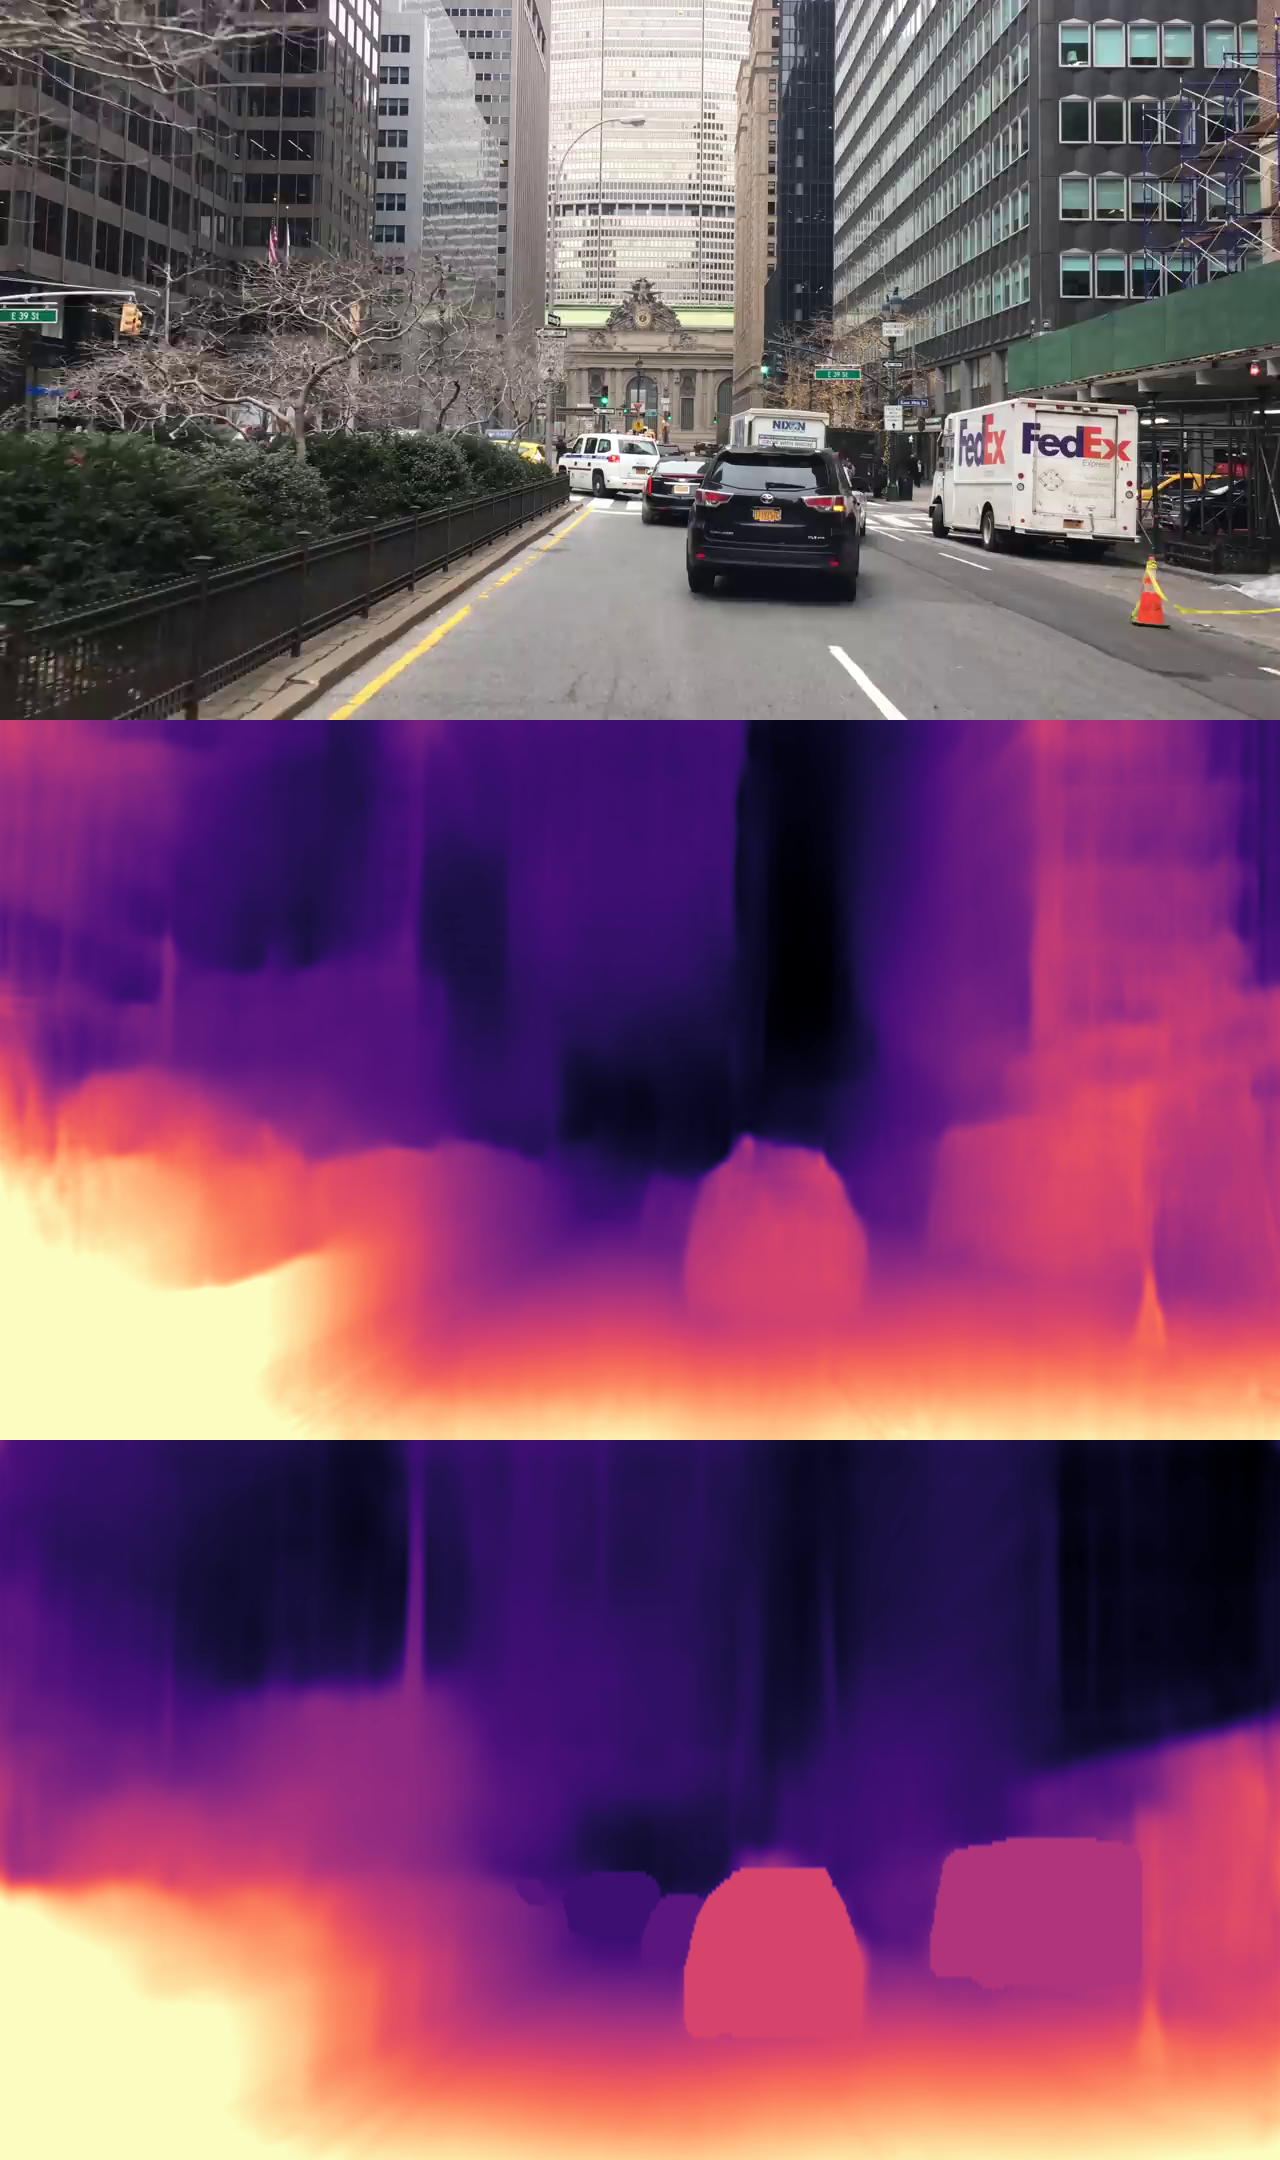

In [19]:
dest

In [17]:
video_out.release()